# **Discrete-Time Systems & Simulation**

**Goal of today:**  
Understand how continuous-time dynamics are simulated in discrete time,  
and how the choice of time step (`dt`) affects stability and correctness.

---

## Why this matters

Real physical systems evolve continuously in time, but computers do not.  
Every simulation, controller, estimator, and RL environment ultimately relies on **discrete-time approximations** of continuous dynamics.

This notebook explores:
- How continuous dynamics are discretized
- How a simple simulation loop works
- Why numerical instability can appear even when the physical system is stable

The focus is **intuition**, not performance or software structure.

## Core idea

Continuous-time system:

$$
\dot{x}(t) = f(x(t), u(t))
$$

Discrete-time approximation (forward Euler):

$$x_{k+1} = x_k + \Delta t \cdot f(x_k, u_k)$$

The time step $\Delta t$ is not an implementation detail —  
it fundamentally changes system behavior.

## What to watch for today

- Effect of changing `dt`
- Stable vs unstable simulations
- Mismatch between physical stability and numerical stability

Failures are expected and documented.

---

## System under study

We start with the simplest possible stable continuous-time system:

$$
\dot{x} = -a x
$$

- This system is **physically stable** for any $a > 0$
- The true continuous solution decays exponentially to zero

We will simulate this system in discrete time using **forward Euler integration**
and observe its behavior.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# System parameter
a = 1.0

def dynamics(x):
    return -a * x

## Discrete-time simulation loop (Forward Euler)

We simulate the continuous system $\dot{x}=-ax$ using the forward Euler update:

$$
x_{k+1} = x_k + dt \cdot (-a x_k) = (1 - a\,dt)\,x_k
$$

We'll:
- run a simulation for a fixed duration
- return time history $t$ and state history $x$

This will let us compare different `dt` values later.

In [3]:
def simulate_euler(x0, dt, T):
    """
    Simulate x_dot = -a x using forward Euler.
    Returns: t (N,), x (N,)
    """
    N = int(np.floor(T / dt)) + 1
    t = np.linspace(0.0, dt*(N-1), N)
    x = np.zeros(N)
    x[0] = x0

    for k in range(N - 1):
        x[k+1] = x[k] + dt * dynamics(x[k])

    return t, x

# quick sanity run (no plotting yet)
x0 = 1.0
dt = 0.1
T = 5.0
t_test, x_test = simulate_euler(x0, dt, T)

print("N =", len(t_test))
print("x(T) =", x_test[-1])
print("first 5 x:", x_test[:5])

N = 51
x(T) = 0.005153775207320112
first 5 x: [1.     0.9    0.81   0.729  0.6561]


## Effect of time step on numerical stability

The continuous-time system $\dot{x} = -a x$ is physically stable.

However, the discrete-time Euler update is:

$$
x_{k+1} = (1 - a\,dt)\,x_k
$$

Stability of the discrete-time system depends on the magnitude of:
$$
|1 - a\,dt|
$$

- If $|1 - a\,dt| < 1$ → **stable**
- If $|1 - a\,dt| > 1$ → **unstable**

We now simulate the same system with **different values of `dt`**
to observe how numerical instability appears.

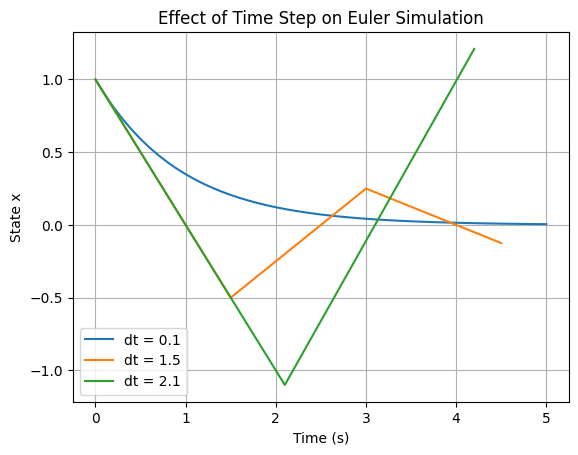

In [5]:
# Compare different dt values
x0 = 1.0
T = 5.0
dt_values = [0.1, 1.5, 2.1]

plt.figure()
for dt in dt_values:
    t, x = simulate_euler(x0, dt, T)
    plt.plot(t, x, label=f"dt = {dt}")

plt.xlabel("Time (s)")
plt.ylabel("State x")
plt.title("Effect of Time Step on Euler Simulation")
plt.legend()
plt.grid(True)
plt.show()

## Observations and intuition

All simulations correspond to the *same continuous-time system*:
$$
\dot{x} = -a x
$$
which is physically stable.

However, the discrete-time Euler update depends on the factor:
$$
x_{k+1} = (1 - a\,dt)\,x_k
$$

From the plots:

- **dt = 0.1**  
  The discrete-time system behaves as expected.  
  The state decays smoothly toward zero, closely matching the true continuous solution.

- **dt = 1.5**  
  The system remains bounded but shows oscillatory behavior.  
  The discrete-time multiplier is negative but its magnitude is less than one, causing alternating signs with decay.

- **dt = 2.1**  
  The simulation becomes numerically unstable and diverges.  
  Even though the physical system is stable, the discrete-time update amplifies errors due to a large time step.

## Key lesson

A system can be **physically stable** but **numerically unstable**.

Numerical stability is not guaranteed by physics alone —  
it depends critically on the discretization method and the chosen time step.

---

## Analytical stability condition (Euler discretization)

For the continuous-time system:
$$
\dot{x} = -a x
$$

The forward Euler discretization gives:
$$
x_{k+1} = (1 - a\,dt)\,x_k
$$

This is a discrete-time linear system with eigenvalue:
$$
\lambda_d = 1 - a\,dt
$$

A discrete-time system is stable **iff**:
$$
|\lambda_d| < 1
$$

Therefore, Euler stability requires:
$$
|1 - a\,dt| < 1
\quad \Rightarrow \quad
0 < dt < \frac{2}{a}
$$

This condition is **numerical**, not physical.

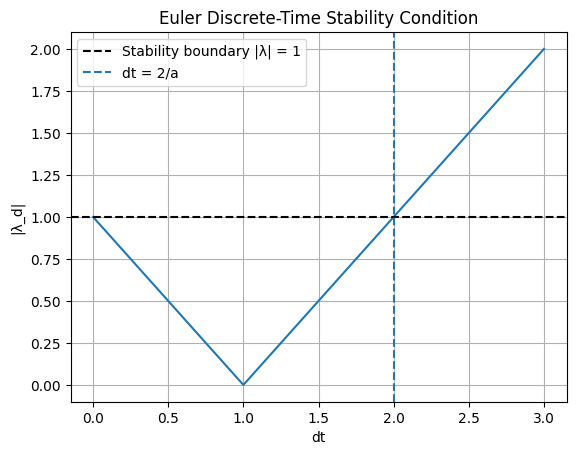

In [6]:
# Verify the analytical stability condition numerically
a = 1.0
dt_test = np.linspace(0.0, 3.0, 400)
lambda_d = 1 - a * dt_test

plt.figure()
plt.plot(dt_test, np.abs(lambda_d))
plt.axhline(1.0, linestyle="--", color="k", label="Stability boundary |λ| = 1")
plt.axvline(2.0 / a, linestyle="--", label="dt = 2/a")

plt.xlabel("dt")
plt.ylabel("|λ_d|")
plt.title("Euler Discrete-Time Stability Condition")
plt.legend()
plt.grid(True)
plt.show()

## Euler vs exact discretization

For $\dot{x} = -a x$, the exact discrete-time solution over a time step $dt$ is:

$$
x_{k+1} = e^{-a\,dt} x_k
$$

This discretization is **unconditionally stable** for any $dt > 0$.

We compare:
- Forward Euler discretization
- Exact discretization

using the same time step.

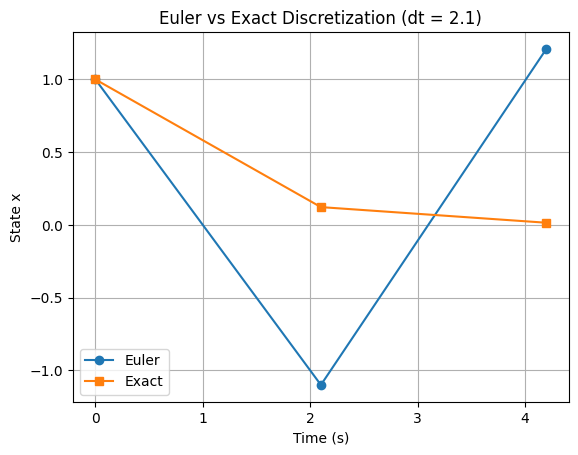

In [7]:
def simulate_exact(x0, dt, T):
    N = int(np.floor(T / dt)) + 1
    t = np.linspace(0.0, dt*(N-1), N)
    x = np.zeros(N)
    x[0] = x0

    for k in range(N - 1):
        x[k+1] = np.exp(-a * dt) * x[k]

    return t, x


# Compare Euler vs Exact for a large dt
x0 = 1.0
T = 5.0
dt = 2.1  # intentionally unstable for Euler

t_e, x_euler = simulate_euler(x0, dt, T)
t_x, x_exact = simulate_exact(x0, dt, T)

plt.figure()
plt.plot(t_e, x_euler, "o-", label="Euler")
plt.plot(t_x, x_exact, "s-", label="Exact")
plt.xlabel("Time (s)")
plt.ylabel("State x")
plt.title(f"Euler vs Exact Discretization (dt = {dt})")
plt.legend()
plt.grid(True)
plt.show()

## Final takeaway

Discretization is a modeling choice, not an implementation detail.

Even for a physically stable system:
- a poor discretization method
- or an overly large time step

can introduce numerical instability.

Understanding this distinction is critical for simulation,
control design, estimation, and learning-based systems.

---